In [1]:
%pushd cs231n/datasets
!   bash get_datasets.sh
%popd

/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1/cs231n/datasets
/Users/jleem/Gaebal/@AI/cs231n/assignments/assignment1
popd -> ~/Gaebal/@AI/cs231n/assignments/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


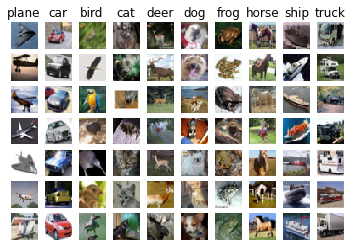

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


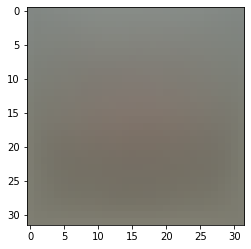

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))  # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss,))

loss: 9.040933


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 45.397423 analytic: 45.397423, relative error: 7.706070e-13
numerical: -18.532200 analytic: -18.532200, relative error: 9.852003e-12
numerical: -9.091287 analytic: -9.116477, relative error: 1.383468e-03
numerical: 8.728902 analytic: 8.728902, relative error: 3.085623e-11
numerical: -34.421229 analytic: -34.421229, relative error: 1.521048e-12
numerical: 18.064444 analytic: 18.064444, relative error: 2.098408e-11
numerical: 1.955769 analytic: 2.003214, relative error: 1.198396e-02
numerical: -14.241113 analytic: -14.263633, relative error: 7.900411e-04
numerical: -1.514930 analytic: -1.514930, relative error: 2.172783e-10
numerical: 7.406941 analytic: 7.406941, relative error: 1.291496e-11
numerical: 7.432033 analytic: 7.328063, relative error: 7.043979e-03
numerical: -7.321756 analytic: -7.321756, relative error: 4.113512e-11
numerical: -26.599428 analytic: -26.599428, relative error: 8.555479e-12
numerical: 2.933890 analytic: 2.912136, relative error: 3.721167e-03
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

Since it is non-differentiable near max=0, the analytical gradient will be calculated either as 0 or as the slope of the function at that point. The analytical gradient will be calculated as 0 or as the slope of the function at that point, which makes it differs from the numerical gradient.

In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.040933e+00 computed in 0.093696s
Vectorized loss: 9.040933e+00 computed in 0.005111s
difference: -0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.092246s
Vectorized loss and gradient: computed in 0.003215s
difference: 0.000000


In [12]:
def visualize_weight(W):
    accuracy = np.mean(y_test == np.argmax(X_test @ W, axis=1))
    print('Accuracy: %f' % (accuracy,))

    # Set background to white
    plt.rcParams['figure.facecolor'] = 'white'
    # Plot size in inches
    figsize_prev = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (20, 10)

    w = W[:-1, :]  # strip out the bias
    w = w.reshape(32, 32, 3, 10)
    w_min, w_max = np.min(w), np.max(w)
    print('w_min: %f, w_max: %f' % (w_min, w_max))
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(1, 10, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)

        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])
    plt.rcParams['figure.figsize'] = figsize_prev

in attempt 0 the loss was 8.963809, best 8.963809
in attempt 1 the loss was 9.444105, best 8.963809
in attempt 2 the loss was 9.249064, best 8.963809
in attempt 3 the loss was 9.594601, best 8.963809
in attempt 4 the loss was 8.940094, best 8.940094
in attempt 5 the loss was 9.193037, best 8.940094
in attempt 6 the loss was 9.103811, best 8.940094
in attempt 7 the loss was 8.402748, best 8.402748
in attempt 8 the loss was 9.211566, best 8.402748
in attempt 9 the loss was 8.724502, best 8.402748
in attempt 10 the loss was 8.937087, best 8.402748
in attempt 11 the loss was 9.280658, best 8.402748
in attempt 12 the loss was 9.184015, best 8.402748
in attempt 13 the loss was 8.920297, best 8.402748
in attempt 14 the loss was 9.173380, best 8.402748
in attempt 15 the loss was 9.372404, best 8.402748
in attempt 16 the loss was 9.130779, best 8.402748
in attempt 17 the loss was 8.758357, best 8.402748
in attempt 18 the loss was 8.995012, best 8.402748
in attempt 19 the loss was 9.052202, best

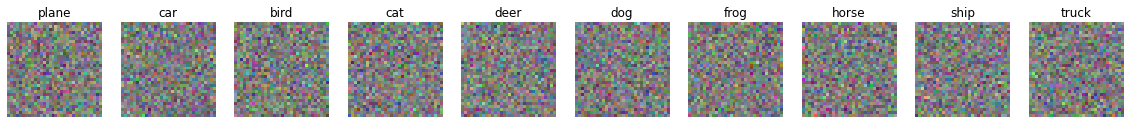

In [13]:
# Random search
bestloss = float("inf")
for num in range(200):
    W = np.random.randn(3073, 10) * 0.0001
    loss, _ = svm_loss_vectorized(W, X_train, y_train, 0.000005)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

visualize_weight(bestW)

in attempt 0 the loss was 9.059907, best 9.059907
in attempt 1 the loss was 9.174260, best 9.059907
in attempt 2 the loss was 9.374108, best 9.059907
in attempt 3 the loss was 8.773869, best 8.773869
in attempt 4 the loss was 9.091967, best 8.773869
in attempt 5 the loss was 8.794240, best 8.773869
in attempt 6 the loss was 9.251232, best 8.773869
in attempt 7 the loss was 9.285226, best 8.773869
in attempt 8 the loss was 8.812486, best 8.773869
in attempt 9 the loss was 8.602730, best 8.602730
in attempt 10 the loss was 8.526557, best 8.526557
in attempt 11 the loss was 8.763168, best 8.526557
in attempt 12 the loss was 9.222005, best 8.526557
in attempt 13 the loss was 9.040889, best 8.526557
in attempt 14 the loss was 9.252083, best 8.526557
in attempt 15 the loss was 8.861929, best 8.526557
in attempt 16 the loss was 9.071628, best 8.526557
in attempt 17 the loss was 9.196167, best 8.526557
in attempt 18 the loss was 9.435002, best 8.526557
in attempt 19 the loss was 9.379309, best

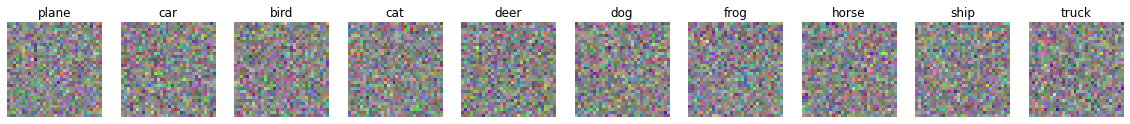

In [14]:
# Blindfolded monkey approach
bestloss = float("inf")
W = np.random.randn(3073, 10) * 0.0001
for num in range(200):
    step_size = 0.0001
    Wtry = W + np.random.randn(3073, 10) * step_size
    loss, _ = svm_loss_vectorized(Wtry, X_train, y_train, 0.000005)
    if (loss < bestloss):
        bestloss = loss
        bestW = Wtry
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

visualize_weight(bestW)

in attempt 0 the loss was 19.094213, best 19.094213
step size is now 0.000010
in attempt 1 the loss was 25.624369, best 19.094213
step size is now 0.000009
in attempt 2 the loss was 27.187233, best 19.094213
step size is now 0.000009
in attempt 3 the loss was 26.349264, best 19.094213
step size is now 0.000008
in attempt 4 the loss was 22.330566, best 19.094213
step size is now 0.000008
in attempt 5 the loss was 22.795976, best 19.094213
step size is now 0.000007
in attempt 6 the loss was 21.152294, best 19.094213
step size is now 0.000007
in attempt 7 the loss was 19.588514, best 19.094213
in attempt 8 the loss was 18.205622, best 18.205622
in attempt 9 the loss was 17.722349, best 17.722349
in attempt 10 the loss was 17.627265, best 17.627265
step size is now 0.000007
in attempt 11 the loss was 17.945429, best 17.627265
in attempt 12 the loss was 17.397567, best 17.397567
in attempt 13 the loss was 16.436049, best 16.436049
in attempt 14 the loss was 16.040090, best 16.040090
step si

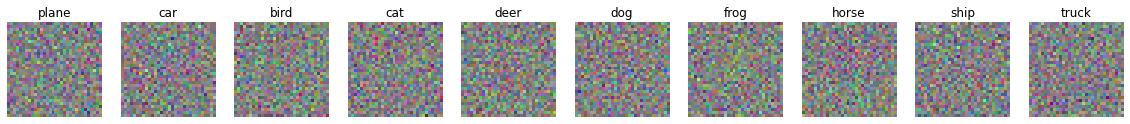

In [15]:
# Gradient Descent
bestloss = float("inf")
W = np.random.randn(3073, 10) * 0.001
step_size = 0.00001
for num in range(200):
    loss, grad = svm_loss_vectorized(W, X_train, y_train, 0.000005)
    W -= step_size * grad
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    else:
        step_size *= 0.95
        print('step size is now %f' % (step_size,))
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

visualize_weight(bestW)

in attempt 0 the loss was 31.536698, best 31.536698
in attempt 1 the loss was 24.192975, best 24.192975
step size is now 0.000010
in attempt 2 the loss was 27.625640, best 24.192975
step size is now 0.000009
in attempt 3 the loss was 25.994036, best 24.192975
in attempt 4 the loss was 22.568608, best 22.568608
step size is now 0.000009
in attempt 5 the loss was 24.844284, best 22.568608
step size is now 0.000008
in attempt 6 the loss was 22.812861, best 22.568608
in attempt 7 the loss was 21.141430, best 21.141430
step size is now 0.000008
in attempt 8 the loss was 21.985446, best 21.141430
in attempt 9 the loss was 20.952766, best 20.952766
in attempt 10 the loss was 19.961055, best 19.961055
step size is now 0.000007
in attempt 11 the loss was 20.397774, best 19.961055
in attempt 12 the loss was 17.305639, best 17.305639
step size is now 0.000007
in attempt 13 the loss was 18.318182, best 17.305639
step size is now 0.000007
in attempt 14 the loss was 18.596118, best 17.305639
in atte

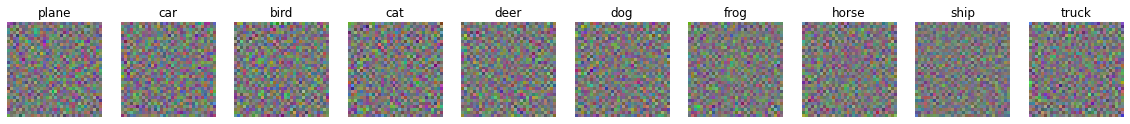

In [16]:
# Gradient Descent (batched)

n_samples = X_train.shape[0]
batch_size = 100
n_batches = n_samples // batch_size
bestloss = float("inf")
W = np.random.randn(3073, 10) * 0.001
step_size = 0.00001

for num in range(200):
    for batch in range(n_batches):
        X_batch = X_train[batch * batch_size: (batch + 1) * batch_size]
        y_batch = y_train[batch * batch_size: (batch + 1) * batch_size]
        loss, grad = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
        W -= step_size * grad
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    else:
        step_size *= 0.95
        print('step size is now %f' % (step_size,))
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

visualize_weight(bestW)

## SVM with hidden layer

In [83]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized_2
import itertools


def train_model(X_train, y_train, X_val, y_val, hidden_dim, reg, step_size, noise=0, batch_size=None, num_epochs=None,
                step_size_decay=0.95):
    num_samples = X_train.shape[0]
    out_dim = X_train.shape[1]
    num_classes = 10
    if batch_size is None or batch_size > num_samples:
        batch_size = num_samples
    num_batches = num_samples // batch_size
    bestloss = float("inf")
    loss = bestloss
    W1 = np.random.randn(out_dim, hidden_dim) * 0.001
    W2 = np.random.randn(hidden_dim, num_classes) * 0.001

    num_retries = 0
    epoch_iter = np.nditer(np.arange(num_epochs), flags=['f_index'])

    while not epoch_iter.finished:
        epoch = epoch_iter.iterindex

        for batch in range(num_batches):
            X_batch = X_train[batch * batch_size: (batch + 1) * batch_size]
            X_noise = np.random.randn(*X_batch.shape) * noise
            y_batch = y_train[batch * batch_size: (batch + 1) * batch_size]
            loss, dW1, dW2 = svm_loss_vectorized_2(W1, W2, X_batch + X_noise, y_batch, reg)
            W1 -= step_size * dW1
            W2 -= step_size * dW2

        print('[Epoch %3d] loss: %f, bestloss: %f' % (epoch, loss, bestloss))
        if (noise > 0):
            loss_without_noise, _, _ = svm_loss_vectorized_2(W1, W2, X_batch, y_batch, reg)
            print('\twithout noise: %f' % (loss_without_noise,))

        if (loss < bestloss):
            bestloss = loss
        else:
            if num_retries > 10:
                print('Abort training')
                break
            if num_retries >= 2:
                step_size *= step_size_decay
                print('Retrying with step size %.10f' % (step_size,))
            else:
                print('Retrying')
            num_retries += 1
            continue

        epoch_iter.iternext()
        num_retries = 0

    accuracy = np.mean(y_val == np.argmax(np.maximum(0, X_val @ W1) @ W2, axis=1))
    print('Validation accuracy(non-linear): %f' % (accuracy,))
    return W1, W2

[Epoch   0] loss: 9.010923, bestloss: inf
[Epoch   1] loss: 8.920346, bestloss: 9.010923
[Epoch   2] loss: 8.826819, bestloss: 8.920346
[Epoch   3] loss: 8.725401, bestloss: 8.826819
[Epoch   4] loss: 8.610579, bestloss: 8.725401
[Epoch   5] loss: 8.475865, bestloss: 8.610579
[Epoch   6] loss: 8.313654, bestloss: 8.475865
[Epoch   7] loss: 8.119116, bestloss: 8.313654
[Epoch   8] loss: 7.902264, bestloss: 8.119116
[Epoch   9] loss: 7.692721, bestloss: 7.902264
[Epoch  10] loss: 7.508075, bestloss: 7.692721
[Epoch  11] loss: 7.346331, bestloss: 7.508075
[Epoch  12] loss: 7.206354, bestloss: 7.346331
[Epoch  13] loss: 7.086216, bestloss: 7.206354
[Epoch  14] loss: 6.981680, bestloss: 7.086216
[Epoch  15] loss: 6.888248, bestloss: 6.981680
[Epoch  16] loss: 6.802366, bestloss: 6.888248
[Epoch  17] loss: 6.722341, bestloss: 6.802366
[Epoch  18] loss: 6.646792, bestloss: 6.722341
[Epoch  19] loss: 6.575005, bestloss: 6.646792
[Epoch  20] loss: 6.505886, bestloss: 6.575005
[Epoch  21] loss: 

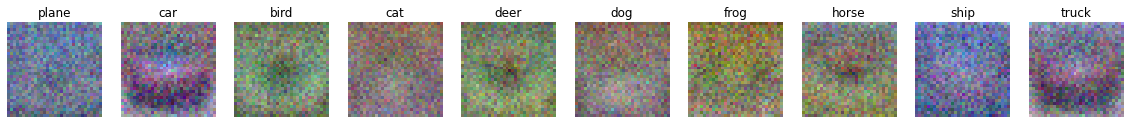

In [84]:
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.000005, step_size=0.0001, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.001835, bestloss: inf
[Epoch   1] loss: 8.874564, bestloss: 9.001835
[Epoch   2] loss: 8.743932, bestloss: 8.874564
[Epoch   3] loss: 8.602483, bestloss: 8.743932
[Epoch   4] loss: 8.440494, bestloss: 8.602483
[Epoch   5] loss: 8.246589, bestloss: 8.440494
[Epoch   6] loss: 8.008327, bestloss: 8.246589
[Epoch   7] loss: 7.721860, bestloss: 8.008327
[Epoch   8] loss: 7.414561, bestloss: 7.721860
[Epoch   9] loss: 7.139939, bestloss: 7.414561
[Epoch  10] loss: 6.907481, bestloss: 7.139939
[Epoch  11] loss: 6.695885, bestloss: 6.907481
[Epoch  12] loss: 6.512635, bestloss: 6.695885
[Epoch  13] loss: 6.357204, bestloss: 6.512635
[Epoch  14] loss: 6.225416, bestloss: 6.357204
[Epoch  15] loss: 6.108913, bestloss: 6.225416
[Epoch  16] loss: 6.001134, bestloss: 6.108913
[Epoch  17] loss: 5.898441, bestloss: 6.001134
[Epoch  18] loss: 5.800589, bestloss: 5.898441
[Epoch  19] loss: 5.706144, bestloss: 5.800589
[Epoch  20] loss: 5.613731, bestloss: 5.706144
[Epoch  21] loss: 

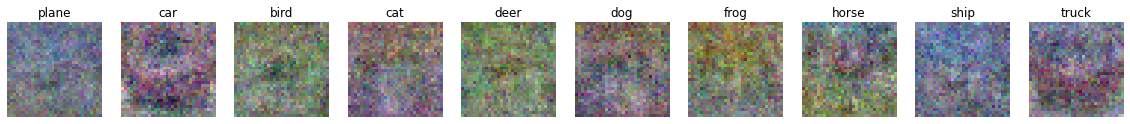

In [19]:
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.000005, step_size=0.0001, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.005445, bestloss: inf
[Epoch   1] loss: 8.865985, bestloss: 9.005445
[Epoch   2] loss: 8.721788, bestloss: 8.865985
[Epoch   3] loss: 8.563816, bestloss: 8.721788
[Epoch   4] loss: 8.381871, bestloss: 8.563816
[Epoch   5] loss: 8.162861, bestloss: 8.381871
[Epoch   6] loss: 7.897714, bestloss: 8.162861
[Epoch   7] loss: 7.613761, bestloss: 7.897714
[Epoch   8] loss: 7.364737, bestloss: 7.613761
[Epoch   9] loss: 7.148845, bestloss: 7.364737
[Epoch  10] loss: 6.940023, bestloss: 7.148845
[Epoch  11] loss: 6.735912, bestloss: 6.940023
[Epoch  12] loss: 6.545715, bestloss: 6.735912
[Epoch  13] loss: 6.376427, bestloss: 6.545715
[Epoch  14] loss: 6.234827, bestloss: 6.376427
[Epoch  15] loss: 6.111446, bestloss: 6.234827
[Epoch  16] loss: 6.000051, bestloss: 6.111446
[Epoch  17] loss: 5.895501, bestloss: 6.000051
[Epoch  18] loss: 5.793799, bestloss: 5.895501
[Epoch  19] loss: 5.696516, bestloss: 5.793799
[Epoch  20] loss: 5.603310, bestloss: 5.696516
[Epoch  21] loss: 

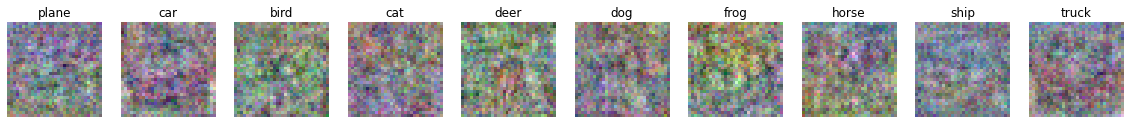

In [20]:
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.000005, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

# Overfitted!

[Epoch   0] loss: 9.236915, bestloss: inf
[Epoch   1] loss: 9.091352, bestloss: 9.236915
[Epoch   2] loss: 8.938341, bestloss: 9.091352
[Epoch   3] loss: 8.767654, bestloss: 8.938341
[Epoch   4] loss: 8.567870, bestloss: 8.767654
[Epoch   5] loss: 8.329525, bestloss: 8.567870
[Epoch   6] loss: 8.052886, bestloss: 8.329525
[Epoch   7] loss: 7.772110, bestloss: 8.052886
[Epoch   8] loss: 7.535914, bestloss: 7.772110
[Epoch   9] loss: 7.324800, bestloss: 7.535914
[Epoch  10] loss: 7.123752, bestloss: 7.324800
[Epoch  11] loss: 6.931987, bestloss: 7.123752
[Epoch  12] loss: 6.761941, bestloss: 6.931987
[Epoch  13] loss: 6.616079, bestloss: 6.761941
[Epoch  14] loss: 6.488427, bestloss: 6.616079
[Epoch  15] loss: 6.373086, bestloss: 6.488427
[Epoch  16] loss: 6.265639, bestloss: 6.373086
[Epoch  17] loss: 6.165062, bestloss: 6.265639
[Epoch  18] loss: 6.069738, bestloss: 6.165062
[Epoch  19] loss: 5.978191, bestloss: 6.069738
[Epoch  20] loss: 5.888667, bestloss: 5.978191
[Epoch  21] loss: 

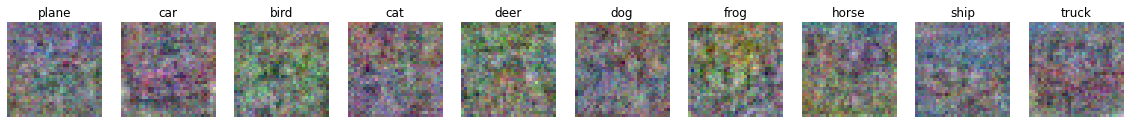

In [21]:
# With high regularization
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.5, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 63.072575, bestloss: inf
[Epoch   1] loss: 60.808517, bestloss: 63.072575
[Epoch   2] loss: 58.641528, bestloss: 60.808517
[Epoch   3] loss: 56.559846, bestloss: 58.641528
[Epoch   4] loss: 54.551843, bestloss: 56.559846
[Epoch   5] loss: 52.606800, bestloss: 54.551843
[Epoch   6] loss: 50.714359, bestloss: 52.606800
[Epoch   7] loss: 48.862277, bestloss: 50.714359
[Epoch   8] loss: 47.044877, bestloss: 48.862277
[Epoch   9] loss: 45.291859, bestloss: 47.044877
[Epoch  10] loss: 43.645695, bestloss: 45.291859
[Epoch  11] loss: 42.091531, bestloss: 43.645695
[Epoch  12] loss: 40.604532, bestloss: 42.091531
[Epoch  13] loss: 39.180247, bestloss: 40.604532
[Epoch  14] loss: 37.818617, bestloss: 39.180247
[Epoch  15] loss: 36.524019, bestloss: 37.818617
[Epoch  16] loss: 35.291847, bestloss: 36.524019
[Epoch  17] loss: 34.117799, bestloss: 35.291847
[Epoch  18] loss: 32.995767, bestloss: 34.117799
[Epoch  19] loss: 31.922508, bestloss: 32.995767
[Epoch  20] loss: 30.89459

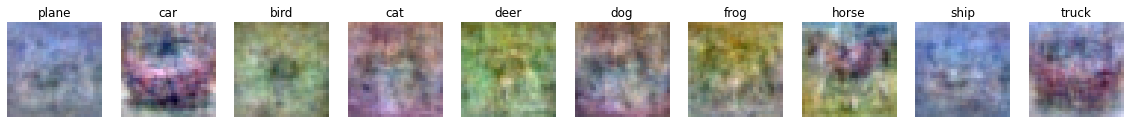

In [22]:
# With high regularization
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=100, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 170.888008, bestloss: inf
[Epoch   1] loss: 151.933501, bestloss: 170.888008
[Epoch   2] loss: 135.207221, bestloss: 151.933501
[Epoch   3] loss: 120.440263, bestloss: 135.207221
[Epoch   4] loss: 107.396949, bestloss: 120.440263
[Epoch   5] loss: 95.871488, bestloss: 107.396949
[Epoch   6] loss: 85.683251, bestloss: 95.871488
[Epoch   7] loss: 76.672460, bestloss: 85.683251
[Epoch   8] loss: 68.698962, bestloss: 76.672460
[Epoch   9] loss: 61.637974, bestloss: 68.698962
[Epoch  10] loss: 55.381069, bestloss: 61.637974
[Epoch  11] loss: 49.836158, bestloss: 55.381069
[Epoch  12] loss: 44.935763, bestloss: 49.836158
[Epoch  13] loss: 40.618719, bestloss: 44.935763
[Epoch  14] loss: 36.816078, bestloss: 40.618719
[Epoch  15] loss: 33.456708, bestloss: 36.816078
[Epoch  16] loss: 30.486303, bestloss: 33.456708
[Epoch  17] loss: 27.859222, bestloss: 30.486303
[Epoch  18] loss: 25.536396, bestloss: 27.859222
[Epoch  19] loss: 23.483471, bestloss: 25.536396
[Epoch  20] loss

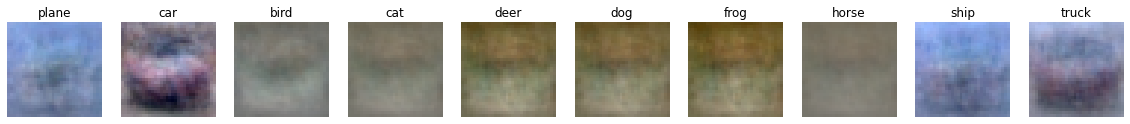

In [23]:
# With high regularization
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=300, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

# bird, cat, deer, dog, frog, horse showing similar patterns...

[Epoch   0] loss: 8.985278, bestloss: inf
	without noise: 8.852138
[Epoch   1] loss: 8.852157, bestloss: 8.985278
	without noise: 8.713395
[Epoch   2] loss: 8.713582, bestloss: 8.852157
	without noise: 8.560780
[Epoch   3] loss: 8.561322, bestloss: 8.713582
	without noise: 8.383379
[Epoch   4] loss: 8.382838, bestloss: 8.561322
	without noise: 8.168791
[Epoch   5] loss: 8.168489, bestloss: 8.382838
	without noise: 7.903843
[Epoch   6] loss: 7.903447, bestloss: 8.168489
	without noise: 7.589485
[Epoch   7] loss: 7.589042, bestloss: 7.903447
	without noise: 7.301079
[Epoch   8] loss: 7.300881, bestloss: 7.589042
	without noise: 7.066077
[Epoch   9] loss: 7.065746, bestloss: 7.300881
	without noise: 6.860027
[Epoch  10] loss: 6.859660, bestloss: 7.065746
	without noise: 6.671140
[Epoch  11] loss: 6.671098, bestloss: 6.859660
	without noise: 6.502054
[Epoch  12] loss: 6.502595, bestloss: 6.671098
	without noise: 6.356170
[Epoch  13] loss: 6.356525, bestloss: 6.502595
	without noise: 6.2330

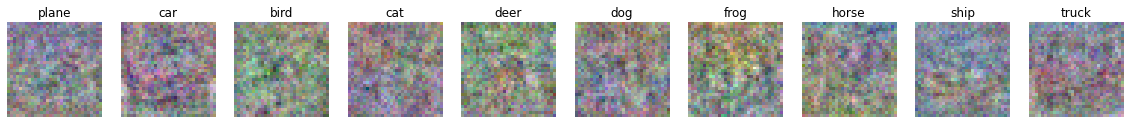

In [24]:
# With noise
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.000005, noise=1, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.041174, bestloss: inf
	without noise: 8.907920
[Epoch   1] loss: 8.905008, bestloss: 9.041174
	without noise: 8.773522
[Epoch   2] loss: 8.776681, bestloss: 8.905008
	without noise: 8.627432
[Epoch   3] loss: 8.633087, bestloss: 8.776681
	without noise: 8.459856
[Epoch   4] loss: 8.466306, bestloss: 8.633087
	without noise: 8.260295
[Epoch   5] loss: 8.265551, bestloss: 8.466306
	without noise: 8.016457
[Epoch   6] loss: 8.010278, bestloss: 8.265551
	without noise: 7.738122
[Epoch   7] loss: 7.738301, bestloss: 8.010278
	without noise: 7.492754
[Epoch   8] loss: 7.496364, bestloss: 7.738301
	without noise: 7.280836
[Epoch   9] loss: 7.290692, bestloss: 7.496364
	without noise: 7.081481
[Epoch  10] loss: 7.076873, bestloss: 7.290692
	without noise: 6.876263
[Epoch  11] loss: 6.883410, bestloss: 7.076873
	without noise: 6.681069
[Epoch  12] loss: 6.684941, bestloss: 6.883410
	without noise: 6.507702
[Epoch  13] loss: 6.511109, bestloss: 6.684941
	without noise: 6.3570

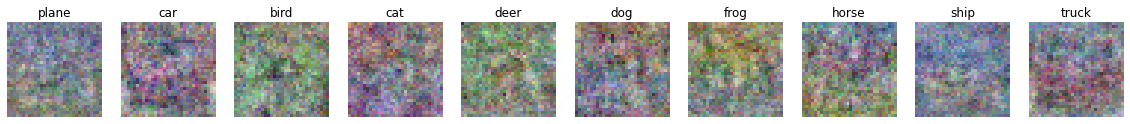

In [25]:
# With noise
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.000005, noise=15, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 63.028409, bestloss: inf
	without noise: 60.765024
[Epoch   1] loss: 60.762745, bestloss: 63.028409
	without noise: 58.600885
[Epoch   2] loss: 58.602803, bestloss: 60.762745
	without noise: 56.520855
[Epoch   3] loss: 56.524857, bestloss: 58.602803
	without noise: 54.513804
[Epoch   4] loss: 54.512102, bestloss: 56.524857
	without noise: 52.570173
[Epoch   5] loss: 52.570991, bestloss: 54.512102
	without noise: 50.679142
[Epoch   6] loss: 50.682454, bestloss: 52.570991
	without noise: 48.834362
[Epoch   7] loss: 48.838453, bestloss: 50.682454
	without noise: 47.038227
[Epoch   8] loss: 47.041874, bestloss: 48.838453
	without noise: 45.315316
[Epoch   9] loss: 45.317056, bestloss: 47.041874
	without noise: 43.694684
[Epoch  10] loss: 43.703118, bestloss: 45.317056
	without noise: 42.154748
[Epoch  11] loss: 42.156054, bestloss: 43.703118
	without noise: 40.673818
[Epoch  12] loss: 40.678427, bestloss: 42.156054
	without noise: 39.246016
[Epoch  13] loss: 39.248424, be

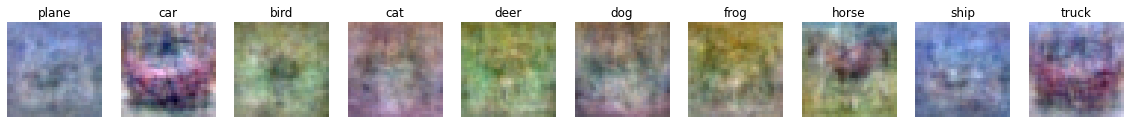

In [26]:
# With noise
W1, W2 = train_model(X_train[:500], y_train, X_val, y_val,
                     hidden_dim=175, reg=100, noise=15, step_size=0.0001, num_epochs=500)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.943027, bestloss: inf
	without noise: 9.365832
[Epoch   1] loss: 7.497852, bestloss: 9.943027
	without noise: 6.896922
[Epoch   2] loss: 6.200752, bestloss: 7.497852
	without noise: 5.593417
[Epoch   3] loss: 5.463343, bestloss: 6.200752
	without noise: 4.857318
[Epoch   4] loss: 5.080826, bestloss: 5.463343
	without noise: 4.470411
[Epoch   5] loss: 4.854967, bestloss: 5.080826
	without noise: 4.238915
[Epoch   6] loss: 4.722617, bestloss: 4.854967
	without noise: 4.104058
[Epoch   7] loss: 4.658300, bestloss: 4.722617
	without noise: 4.030709
[Epoch   8] loss: 4.589700, bestloss: 4.658300
	without noise: 3.970362
[Epoch   9] loss: 4.578703, bestloss: 4.589700
	without noise: 3.942486
[Epoch  10] loss: 4.565690, bestloss: 4.578703
	without noise: 3.919604
[Epoch  11] loss: 4.541513, bestloss: 4.565690
	without noise: 3.880462
[Epoch  12] loss: 4.523000, bestloss: 4.541513
	without noise: 3.879107
[Epoch  13] loss: 4.515580, bestloss: 4.523000
	without noise: 3.8570

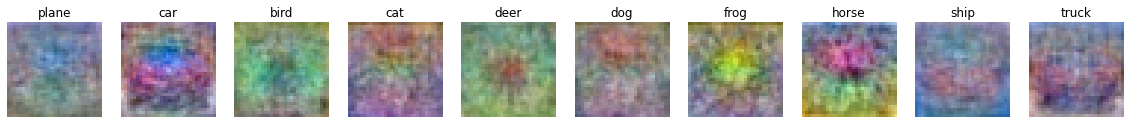

In [27]:
# With noise
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val, batch_size=100,
                     hidden_dim=175, reg=15, noise=2, step_size=0.0001, step_size_decay=0.8, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 7.259811, bestloss: inf
	without noise: 6.668652
[Epoch   1] loss: 6.268358, bestloss: 7.259811
	without noise: 5.622849
[Epoch   2] loss: 5.628807, bestloss: 6.268358
	without noise: 4.967723
[Epoch   3] loss: 5.132534, bestloss: 5.628807
	without noise: 4.454665
[Epoch   4] loss: 4.733193, bestloss: 5.132534
	without noise: 4.027571
[Epoch   5] loss: 4.409658, bestloss: 4.733193
	without noise: 3.707934
[Epoch   6] loss: 4.158756, bestloss: 4.409658
	without noise: 3.449537
[Epoch   7] loss: 4.003867, bestloss: 4.158756
	without noise: 3.271913
[Epoch   8] loss: 3.838467, bestloss: 4.003867
	without noise: 3.094650
[Epoch   9] loss: 3.687198, bestloss: 3.838467
	without noise: 2.936777
[Epoch  10] loss: 3.582675, bestloss: 3.687198
	without noise: 2.838915
[Epoch  11] loss: 3.512570, bestloss: 3.582675
	without noise: 2.750976
[Epoch  12] loss: 3.441476, bestloss: 3.512570
	without noise: 2.680774
[Epoch  13] loss: 3.382484, bestloss: 3.441476
	without noise: 2.6328

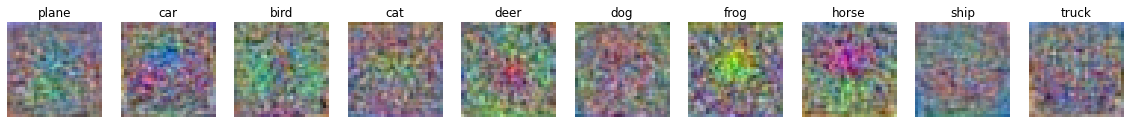

In [28]:
# With noise
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val, batch_size=100,
                     hidden_dim=175, reg=5, noise=1, step_size=0.0001, step_size_decay=0.8, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 4.886048, bestloss: inf
	without noise: 4.289736
[Epoch   1] loss: 4.117190, bestloss: 4.886048
	without noise: 3.479945
[Epoch   2] loss: 3.603367, bestloss: 4.117190
	without noise: 2.936670
[Epoch   3] loss: 3.222700, bestloss: 3.603367
	without noise: 2.540507
[Epoch   4] loss: 2.937151, bestloss: 3.222700
	without noise: 2.261860
[Epoch   5] loss: 2.699685, bestloss: 2.937151
	without noise: 2.044127
[Epoch   6] loss: 2.523060, bestloss: 2.699685
	without noise: 1.854918
[Epoch   7] loss: 2.345842, bestloss: 2.523060
	without noise: 1.688132
[Epoch   8] loss: 2.198034, bestloss: 2.345842
	without noise: 1.531705
[Epoch   9] loss: 2.029228, bestloss: 2.198034
	without noise: 1.395985
[Epoch  10] loss: 1.939178, bestloss: 2.029228
	without noise: 1.287839
[Epoch  11] loss: 1.785029, bestloss: 1.939178
	without noise: 1.132432
[Epoch  12] loss: 1.660490, bestloss: 1.785029
	without noise: 1.040696
[Epoch  13] loss: 1.614818, bestloss: 1.660490
	without noise: 0.9644

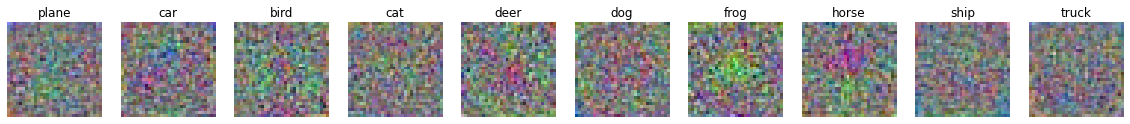

In [29]:
# With noise
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val, batch_size=100,
                     hidden_dim=175, reg=0.05, noise=0.01, step_size=0.0001, step_size_decay=0.8, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.020063, bestloss: inf
	without noise: 8.209203
[Epoch   1] loss: 8.209204, bestloss: 9.020063
	without noise: 7.013063
[Epoch   2] loss: 7.013062, bestloss: 8.209204
	without noise: 6.350241
[Epoch   3] loss: 6.350242, bestloss: 7.013062
	without noise: 5.873138
[Epoch   4] loss: 5.873136, bestloss: 6.350242
	without noise: 5.596443
[Epoch   5] loss: 5.596443, bestloss: 5.873136
	without noise: 5.495015
[Epoch   6] loss: 5.495014, bestloss: 5.596443
	without noise: 5.221064
[Epoch   7] loss: 5.221062, bestloss: 5.495014
	without noise: 5.091837
[Epoch   8] loss: 5.091836, bestloss: 5.221062
	without noise: 4.992788
[Epoch   9] loss: 4.992791, bestloss: 5.091836
	without noise: 5.037312
[Epoch  10] loss: 5.037312, bestloss: 4.992791
	without noise: 4.948759
Retrying with step size 0.0008000000
[Epoch  10] loss: 4.948756, bestloss: 4.992791
	without noise: 4.561020
[Epoch  11] loss: 4.561019, bestloss: 4.948756
	without noise: 4.407685
[Epoch  12] loss: 4.407686, best

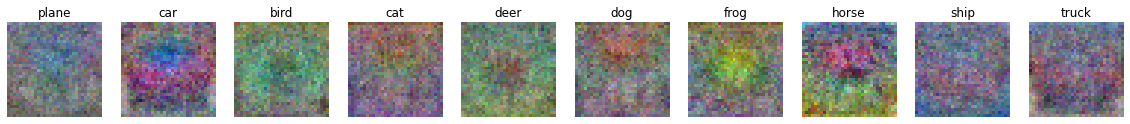

In [31]:
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.05, noise=0.01, step_size=0.001, step_size_decay=0.8, num_epochs=100)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.019137, bestloss: inf
	without noise: 8.200713
[Epoch   1] loss: 8.200713, bestloss: 9.019137
	without noise: 7.060413
[Epoch   2] loss: 7.060412, bestloss: 8.200713
	without noise: 6.403550
[Epoch   3] loss: 6.403550, bestloss: 7.060412
	without noise: 5.934942
[Epoch   4] loss: 5.934943, bestloss: 6.403550
	without noise: 5.666599
[Epoch   5] loss: 5.666599, bestloss: 5.934943
	without noise: 5.584958
[Epoch   6] loss: 5.584957, bestloss: 5.666599
	without noise: 5.230061
[Epoch   7] loss: 5.230063, bestloss: 5.584957
	without noise: 5.043945
[Epoch   8] loss: 5.043945, bestloss: 5.230063
	without noise: 4.962691
[Epoch   9] loss: 4.962691, bestloss: 5.043945
	without noise: 5.091971
[Epoch  10] loss: 5.091971, bestloss: 4.962691
	without noise: 5.133728
Retrying with step size 0.0008000000
[Epoch  10] loss: 5.133730, bestloss: 4.962691
	without noise: 5.004790
Retrying with step size 0.0006400000
[Epoch  10] loss: 5.004787, bestloss: 4.962691
	without noise: 4.59

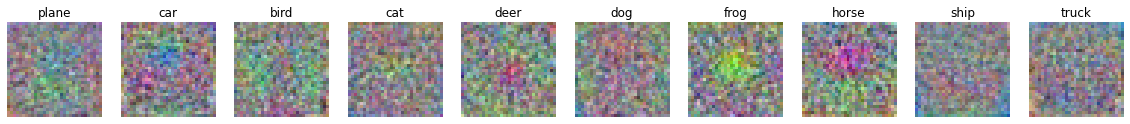

In [38]:
W1, W2 = train_model(X_train[:10000], y_train, X_val, y_val,
                     hidden_dim=175, reg=0.05, noise=0.01, step_size=0.001, step_size_decay=0.8, num_epochs=1000)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.009044, bestloss: inf
	without noise: 8.175396
[Epoch   1] loss: 8.175396, bestloss: 9.009044
	without noise: 7.088569
[Epoch   2] loss: 7.088569, bestloss: 8.175396
	without noise: 6.426679
[Epoch   3] loss: 6.426679, bestloss: 7.088569
	without noise: 5.978188
[Epoch   4] loss: 5.978187, bestloss: 6.426679
	without noise: 5.692998
[Epoch   5] loss: 5.692998, bestloss: 5.978187
	without noise: 5.623690
[Epoch   6] loss: 5.623690, bestloss: 5.692998
	without noise: 5.579685
[Epoch   7] loss: 5.579685, bestloss: 5.623690
	without noise: 5.893520
[Epoch   8] loss: 5.893520, bestloss: 5.579685
	without noise: 5.502731
Retrying with step size 0.0008000000
[Epoch   8] loss: 5.502731, bestloss: 5.579685
	without noise: 5.077548
[Epoch   9] loss: 5.077548, bestloss: 5.502731
	without noise: 4.888013
[Epoch  10] loss: 4.888014, bestloss: 5.077548
	without noise: 4.770575
[Epoch  11] loss: 4.770575, bestloss: 4.888014
	without noise: 4.705433
[Epoch  12] loss: 4.705432, best

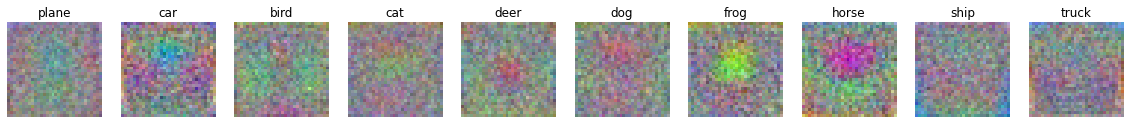

In [39]:
W1, W2 = train_model(X_train, y_train, X_val, y_val,
                     hidden_dim=175, reg=0.05, noise=0.01, step_size=0.001, step_size_decay=0.8, num_epochs=1000)
visualize_weight(W1 @ W2)

[Epoch   0] loss: 9.029471, bestloss: inf
	without noise: 8.269175
[Epoch   1] loss: 8.269175, bestloss: 9.029471
	without noise: 7.032896
[Epoch   2] loss: 7.032896, bestloss: 8.269175
	without noise: 6.344679
[Epoch   3] loss: 6.344679, bestloss: 7.032896
	without noise: 5.928442
[Epoch   4] loss: 5.928442, bestloss: 6.344679
	without noise: 5.678900
[Epoch   5] loss: 5.678900, bestloss: 5.928442
	without noise: 5.581008
[Epoch   6] loss: 5.581009, bestloss: 5.678900
	without noise: 5.368954
[Epoch   7] loss: 5.368953, bestloss: 5.581009
	without noise: 5.436073
[Epoch   8] loss: 5.436072, bestloss: 5.368953
	without noise: 5.592722
Retrying
[Epoch   8] loss: 5.592723, bestloss: 5.368953
	without noise: 6.090833
Retrying
[Epoch   8] loss: 6.090833, bestloss: 5.368953
	without noise: 5.596583
Retrying with step size 0.0009000000
[Epoch   8] loss: 5.596583, bestloss: 5.368953
	without noise: 5.218381
Retrying with step size 0.0008100000
[Epoch   8] loss: 5.218381, bestloss: 5.368953
	w

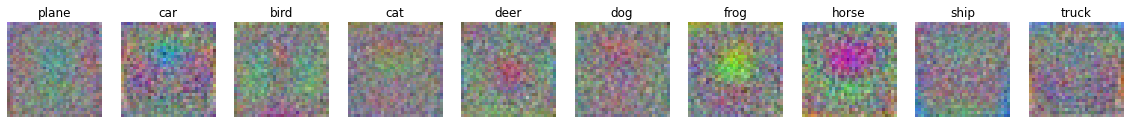

In [41]:
W1, W2 = train_model(X_train, y_train, X_val, y_val,
                     hidden_dim=175, reg=0.05, noise=0.01, step_size=0.001, step_size_decay=0.9, num_epochs=1000)
visualize_weight(W1 @ W2)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [71]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.759361
iteration 100 / 1500: loss 287.583045
iteration 200 / 1500: loss 108.232913
iteration 300 / 1500: loss 42.989589
iteration 400 / 1500: loss 18.662543
iteration 500 / 1500: loss 10.251141
iteration 600 / 1500: loss 6.568531
iteration 700 / 1500: loss 5.819366
iteration 800 / 1500: loss 5.599936
iteration 900 / 1500: loss 5.304152
iteration 1000 / 1500: loss 5.660326
iteration 1100 / 1500: loss 4.717462
iteration 1200 / 1500: loss 5.321465
iteration 1300 / 1500: loss 5.218825
iteration 1400 / 1500: loss 5.224396
That took 5.527071s


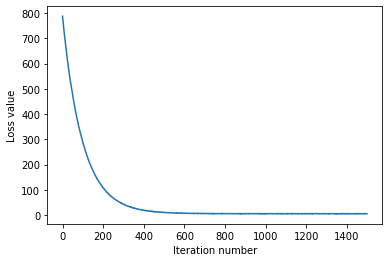

In [72]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [74]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred),))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred),))

training accuracy: 0.371633
validation accuracy: 0.383000


In [129]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1  # The highest validation accuracy that we have seen so far.
best_svm = None  # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [1e-7, 5e-5]
learning_rates_log = [-8, -5]
# regularization_strengths = [2.5e4, 5e4]
regularization_strengths_log = [2.5, 5.5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_iters = 500

learning_rates_it = np.logspace(*learning_rates_log, 15)
regularization_strengths_it = np.logspace(*regularization_strengths_log, 15)
params_it = itertools.product(learning_rates_it, regularization_strengths_it)

for params in params_it:
    learning_rate, regularization_strength = params
    print('learning_rate: %e, regularization_strength: %e' % (learning_rate, regularization_strength))

    svm = LinearSVM()
    loss_hist = svm.train(
        X_train, y_train,
        learning_rate=learning_rate,
        reg=regularization_strength,
        num_iters=num_iters,
        verbose=False
    )
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[params] = (training_accuracy, validation_accuracy)

    print('\t👉 training accuracy: %f, validation accuracy: %f' % (training_accuracy, validation_accuracy))

    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning_rate: 1.000000e-08, regularization_strength: 3.162278e+02
	👉 training accuracy: 0.174122, validation accuracy: 0.183000
learning_rate: 1.000000e-08, regularization_strength: 5.179475e+02
	👉 training accuracy: 0.183449, validation accuracy: 0.205000
learning_rate: 1.000000e-08, regularization_strength: 8.483429e+02
	👉 training accuracy: 0.197755, validation accuracy: 0.186000
learning_rate: 1.000000e-08, regularization_strength: 1.389495e+03
	👉 training accuracy: 0.182898, validation accuracy: 0.194000
learning_rate: 1.000000e-08, regularization_strength: 2.275846e+03
	👉 training accuracy: 0.172000, validation accuracy: 0.186000
learning_rate: 1.000000e-08, regularization_strength: 3.727594e+03
	👉 training accuracy: 0.181796, validation accuracy: 0.188000
learning_rate: 1.000000e-08, regularization_strength: 6.105402e+03
	👉 training accuracy: 0.187633, validation accuracy: 0.185000
learning_rate: 1.000000e-08, regularization_strength: 1.000000e+04
	👉 training accuracy: 0.170755

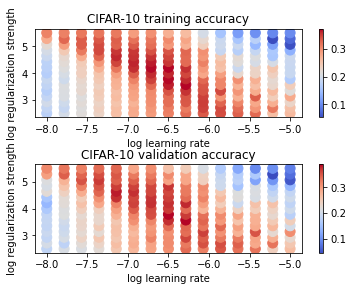

In [130]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results]  # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [131]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.354000


Text(0.5, 1.0, 'truck')

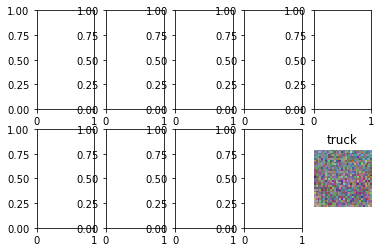

In [132]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1, :]  # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

# Rescale the weights to be between 0 and 255
wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
plt.imshow(wimg.astype('uint8'))
plt.axis('off')
plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
